# Named entity recognition text processing

In order to compare various NER pipelines, we must provide pre-tokenized text to avoid different tokenization processes leading to misaligned text. The text must be aligned at the token level in order to calculate performance metrics (precision, recall, f1).

Below is a list of the various NER pipelines to test with corresponding tasks for text preprocessing
- Prodigy: 
  * tokens can be aligned with spark
- ELMO: 
  * accepts a list of lists of tokens (can inherit spark tokens)
- BERT: 
  * tokens can be aligned with spark
- Spark: 
  * spark has promising models that are worth exploring, but it seems almost impossible to use another tokenizer
  * so, we will use spark's tokenizer as the common tokenizer and align back to it for comparison metrics

### Overview of workflow

- Preprocess text
- ===> Tokenize with spark <===
- Feed tokenizations to prodigy, elmo
  * Process additionally for BERT
- align tokens https://github.com/tamuhey/tokenizations
- compute metrics


### Load packages

In [1]:
from google.colab import files
import json


with open('/content/drive/MyDrive/Crowdfunding/keys.json') as f:
    license_keys = json.load(f)

In [2]:
import os
import csv
import io
import pandas as pd
import numpy as np
import copy
import seaborn as sns
import spacy


secret = license_keys['SECRET']
os.environ['SPARK_NLP_LICENSE'] = license_keys['SPARK_NLP_LICENSE']
os.environ['AWS_ACCESS_KEY_ID'] = license_keys['AWS_ACCESS_KEY_ID']
os.environ['AWS_SECRET_ACCESS_KEY'] = license_keys['AWS_SECRET_ACCESS_KEY']
sparknlp_version = license_keys["PUBLIC_VERSION"]
jsl_version = license_keys["JSL_VERSION"]

print ('SparkNLP Version:', sparknlp_version)
print ('SparkNLP-JSL Version:', jsl_version)

# Install Java
! apt-get update -qq
! apt-get install -y openjdk-8-jdk-headless -qq > /dev/null
! java -version

# Install pyspark
! pip install --ignore-installed -q pyspark==2.4.4

# Install Spark NLP
! pip install --ignore-installed spark-nlp==$sparknlp_version
! python -m pip install --upgrade spark-nlp-jsl==$jsl_version --extra-index-url https://pypi.johnsnowlabs.com/$secret

os.environ['JAVA_HOME'] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ['PATH'] = os.environ['JAVA_HOME'] + "/bin:" + os.environ['PATH']

from pyspark.ml import Pipeline
from pyspark.sql import SparkSession
import pyspark.sql.functions as F
from pyspark.sql.types import *

import sparknlp
from sparknlp.annotator import *
from sparknlp_jsl.annotator import *
from sparknlp.base import *
import sparknlp_jsl

spark = sparknlp_jsl.start(secret)

SparkNLP Version: 2.6.5
SparkNLP-JSL Version: 2.7.2
openjdk version "11.0.9.1" 2020-11-04
OpenJDK Runtime Environment (build 11.0.9.1+1-Ubuntu-0ubuntu1.18.04)
OpenJDK 64-Bit Server VM (build 11.0.9.1+1-Ubuntu-0ubuntu1.18.04, mixed mode, sharing)
     |████████████████████████████████| 215.7MB 31kB/s 
     |████████████████████████████████| 204kB 21.8MB/s 
     |████████████████████████████████| 133kB 4.1MB/s 
Looking in indexes: https://pypi.org/simple, https://pypi.johnsnowlabs.com/2.7.2-7ad44c2a1a61c48b6a74446b0a7cb6b97c58dba0
     |████████████████████████████████| 51kB 1.6MB/s 


### Import feed data

In [3]:
#crowdfunding/json/rounds_3-6_for_prodigy.json
with open('/content/drive/MyDrive/Crowdfunding/rounds_3-6_for_prodigy.json') as json_file:
    feed = json.load(json_file)

In [4]:
feed = pd.DataFrame(feed)
print(feed.shape)
feed.head()

(197, 2)


,url,text
0,https://www.gofundme.com/f/please-help-karens-...,Help save my daughter's healthImagine having a...
1,https://www.gofundme.com/f/patrickwalter,"Patrick Walter is one of the kindest, funniest..."
2,https://www.gofundme.com/f/gspdys,"As most of you know, Alexander was born with H..."
3,https://www.gofundme.com/f/shane-blanchard039s...,"Friends of Shane Blanchard, we are requesting ..."
4,https://www.gofundme.com/f/2t4nqbuk,"Hello everyone, My name is Nicole Manzolli. I ..."


### Text preprocessing

Text has already had the following preprocessing steps in "Make qualtrics survey" notebook


```
feed = feed.drop_duplicates('url')

feed['nchar']= [len(x) for x in feed['fund_description']]
feed = feed[feed['nchar'] >= 100]

#regular expression to remove url
url_reg = r'(?:(?:http|https):\/\/)?([-a-zA-Z0-9.]{2,256}\.[a-z]{2,4})\b(?:\/[-a-zA-Z0-9@:%_\+.~#?&//=]*)?'

#regular expression to remove emojis
emoji_pattern = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
        u"\U0001F1F2-\U0001F1F4"  # Macau flag
        u"\U0001F1E6-\U0001F1FF"  # flags
        u"\U0001F600-\U0001F64F"
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        u"\U0001f926-\U0001f937"
        u"\U0001F1F2"
        u"\U0001F1F4"
        u"\U0001F620"
        u"\u200d"
        u"\u2640-\u2642"
        "]+", flags=re.UNICODE)

feed['fund_description'] = [bs(x).get_text().replace("\n","").replace(u'\xa0', u' ') for x in feed['fund_description']]
feed['fund_description'] = [re.sub(url_reg,"",x) for x in feed['fund_description']]
feed['fund_description'] = [emoji_pattern.sub(r'', x) for x in feed['fund_description']]
feed['fund_description'] = [x.strip() for x in feed['fund_description']]


feed['nchar']= [len(x) for x in feed['fund_description']]
feed = feed[feed['nchar'] >= 100]
```



The spark tokenizer does not work reliably to tokenize on punctuation without whitespace e.g. "end.Beginning"

So will preprocess this manually to split tokens by .,!?

In [5]:
import re

def CustomTokenize(df):
  r = []
  for i in range(len(df)):
    string = re.sub(r'(?<=[.,!\\?])(?=[^\s])', r' ', df['text'][i])
    r.append(string)
  return r

In [6]:
feed.loc[:,'text_clean'] = CustomTokenize(feed)
del feed['text']
feed = feed.rename(columns={'text_clean':'text'})

### Tokenize with Spark NLP

#### Define pipeline elements

In [7]:
document_assembler = DocumentAssembler() \
    .setInputCol('text')\
    .setOutputCol('document')

sentence_detector = SentenceDetector() \
    .setInputCols(['document'])\
    .setOutputCol('sentence')

tokenizer = Tokenizer()\
    .setInputCols(['sentence']) \
    .setOutputCol('token')

#### Define Functions

In [8]:
def Tokenize(feed, first_column):
  '''
  input:
    1. pandas dataframe of feed data, col_1 = "url", col_2 = "text"
    3. string of first column name
  output: pandas dataframe with nested results
  '''

  #initiate empty df
  empty_df = spark.createDataFrame([['']]).toDF(first_column)
  
  #load feed data into df
  df = spark.createDataFrame(feed)
  
  nlp_pipeline = Pipeline(stages=[
      document_assembler, 
      sentence_detector,
      tokenizer])

  model = nlp_pipeline.fit(empty_df)
  result = model.transform(df)
  print('all done')
  return result.toPandas()
  

#### Execute functions

In [9]:
tokenized_text = Tokenize(feed, 'text')

all done


### Inspect tokenized text

In [10]:
tokenized_text.head()

,url,text,document,sentence,token
0,https://www.gofundme.com/f/please-help-karens-...,Help save my daughter's healthImagine having a...,"[(document, 0, 4443, Help save my daughter's h...","[(document, 0, 168, Help save my daughter's he...","[(token, 0, 3, Help, {'sentence': '0'}, []), (..."
1,https://www.gofundme.com/f/patrickwalter,"Patrick Walter is one of the kindest, funniest...","[(document, 0, 678, Patrick Walter is one of t...","[(document, 0, 77, Patrick Walter is one of th...","[(token, 0, 6, Patrick, {'sentence': '0'}, [])..."
2,https://www.gofundme.com/f/gspdys,"As most of you know, Alexander was born with H...","[(document, 0, 531, As most of you know, Alexa...","[(document, 0, 75, As most of you know, Alexan...","[(token, 0, 1, As, {'sentence': '0'}, []), (to..."
3,https://www.gofundme.com/f/shane-blanchard039s...,"Friends of Shane Blanchard, we are requesting ...","[(document, 0, 1598, Friends of Shane Blanchar...","[(document, 0, 165, Friends of Shane Blanchard...","[(token, 0, 6, Friends, {'sentence': '0'}, [])..."
4,https://www.gofundme.com/f/2t4nqbuk,"Hello everyone, My name is Nicole Manzolli. I ...","[(document, 0, 3789, Hello everyone, My name i...","[(document, 0, 42, Hello everyone, My name is ...","[(token, 0, 4, Hello, {'sentence': '0'}, []), ..."


In [11]:
token_length = []
for token_list in tokenized_text['token']:
  token_length.append(len(token_list))

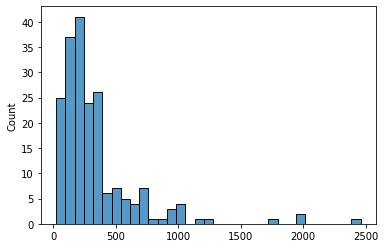

In [12]:
sns.histplot(token_length)

In [13]:
np.mean(token_length)

339.07106598984774

### Prepare data for Prodigy

In [14]:
def Prodigy(df):
  '''
  return list of dictionaries
  for each campaign (i.e. list item) return dic
    {
      "url" : CAMPAIGN URL,
      "tokens" : [
        {"text" : TOKEN, "start" : START CHAR, "end" : END CHAR, "id" : TOKEN INDEX IN SENTENCE}
      ]
    }
  '''
  #define results container
  r = []

  #loop through df
  for i in range(len(df)):
    dic = {}
    tokens = []
    #loop through tokens
    token_rows = df['token'][i]
    n = 0
    for token_row in token_rows:
      tokens_dic = {}
      tokens_dic['text'] = token_row['result']
      tokens_dic['start'] = int(token_row['begin'])
      tokens_dic['end'] = int(token_row['end'])
      tokens_dic['id '] = n
      tokens.append(tokens_dic)
      n = n + 1
    dic['url'] = df['url'][i]
    #dic['tokens'] = tokens
    dic['text'] = df['text'][i]
    r.append(dic)

  print('all done')
  return r

In [15]:
prodigy_data = Prodigy(tokenized_text)

all done


### Prepare data for ELMO

In [16]:
def Elmo(df):
  '''
  input into elmo is list of lists for each document
    length of container list = number of sentences in document
      length of sub list = number of tokens in sentence[i]

  so we will return list of dictionaries
  {
    "url" : CAMPAIGN URL,
    "lol" : LIST OF LISTS as above
  }

  '''
  #define results container
  r = []

  #loop through df and collect token data
  for i in range(len(df)):
    dic = {}
    #loop through tokens
    token_rows = df['token'][i]
    tokens_dic = {'text' : [], 'start' : [], 'end' : [], 'sentence' : []}
    for token_row in token_rows:
      tokens_dic['text'].append(token_row['result'])
      tokens_dic['start'].append(int(token_row['begin']))
      tokens_dic['end'].append(int(token_row['end']))
      tokens_dic['sentence'].append(int(token_row.metadata['sentence']))
    dic['url'] = df['url'][i]
    dic['lol'] = pd.DataFrame(tokens_dic).groupby(['sentence']).agg({'text': lambda x: x.tolist()}).reset_index().sort_values(by='sentence')['text'].tolist()
    r.append(dic)

  print('all done')
  return r

In [17]:
elmo_data = Elmo(tokenized_text)

all done


### Export Prodigy and Elmo data

In [ ]:
# with open('/content/drive/MyDrive/Crowdfunding/prodigy_data_rounds_3-6.json', 'w') as fout:
#     json.dump(prodigy_data , fout)

In [ ]:
# with open('/content/drive/MyDrive/Crowdfunding/elmo_data_rounds_3-6.json', 'w') as fout:
#     json.dump(elmo_data , fout)

### Code to align other tokens with spark

In [20]:
!pip install pytokenizations==0.7.2

     |████████████████████████████████| 245kB 4.2MB/s 


In [21]:
import tokenizations

Import and format prodigy data

In [ ]:
#import prodigy data
import json
p = []
for line in open('/content/drive/MyDrive/Crowdfunding/annotations_rounds_3-6_corrected.json', 'r'):
    p.append(json.loads(line))


In [ ]:
len(p)

394

The dataset was doubled with review, so only take second half

In [ ]:
p = p[int(394/2):]

In [ ]:
len(p)

197

2/8/21

Import prodigy data annotated for DIAGNOSIS, TEST, TREATMENT

In [31]:
#import prodigy data
import json
p = []
for line in open('/content/drive/MyDrive/Crowdfunding/dx_tx_test_annotations_corrected.json', 'r'):
    p.append(json.loads(line))

In [32]:
len(p)

197

In [33]:
#gather text and spans
text = [x['text'] for x in p]
spans = []
for i in range(len(p)):
  if 'spans' in p[i].keys():
    spans.append(p[i]['spans'])
  else:
    spans.append([])

In [34]:
#gather iob tags
prodigy_tags = []
for i in range(len(p)):
  nlp = spacy.blank("en")
  doc = nlp(text[i])
  offsets = [(span["start"], span["end"], span["label"]) for span in spans[i]]
  doc.ents = [doc.char_span(start, end, label) for start, end, label in offsets]
  iob_tags = [f"{t.ent_iob_}-{t.ent_type_}" if t.ent_iob_ else "O" for t in doc]
  prodigy_tags.append(iob_tags)

In [35]:
#gather prodigy tokens
prodigy_tokens = []
for i in range(len(p)):
  tokens = [x['text'] for x in p[i]['tokens']]
  prodigy_tokens.append(tokens)

In [36]:
#gather spark-tokenized tokens
spark_tokens = []
for i in range(len(p)):
  url = p[i]['url']
  df = tokenized_text[tokenized_text['url'] == url]
  idx = df.index.tolist()[0]
  tokens = [x['result'] for x in df['token'][idx]]
  spark_tokens.append(tokens)

In [37]:
def AlignOtherTokensToSpark(prodigy_tokens, prodigy_tags, spark_tokens, is_bert):

  #function inspired by:
  #https://gist.github.com/tamuhey/af6cbb44a703423556c32798e1e1b704

  aligned_tokens = []
  aligned_tags = []

  print('Length of prodigy tokens:',len(prodigy_tokens))
  print('Length of prodigy tags:',len(prodigy_tags))
  print('Length of spark tokens:',len(spark_tokens))

  for i in range(len(spark_tokens)):

    p_tokens = prodigy_tokens[i]
    p_tags = prodigy_tags[i]
    s_tokens = spark_tokens[i]

    #if bert
    if is_bert == 'True':
      print('is BERT')
      p_tokens = p_tokens[1:-1]
      p_tags = p_tags[1:-1]
    

    #align tokens
    a2b, b2a = tokenizations.get_alignments(s_tokens, p_tokens)

    #join aligned tokens and tags into list of same length as reference list
    tokens = []
    tags = []
    for i in range(len(a2b)):
      for j in a2b[i]:
        token = ''.join(p_tokens[j]).replace('#','').strip()
        tag = ''.join(p_tags[j]).strip()
      tokens.append(token)
      tags.append(tag)
    aligned_tokens.append(tokens)
    aligned_tags.append(tags)

  return aligned_tokens, aligned_tags

In [38]:
prodigy_aligned_tokens, prodigy_aligned_tags = AlignOtherTokensToSpark(prodigy_tokens, prodigy_tags, spark_tokens, False)

Length of prodigy tokens: 197
Length of prodigy tags: 197
Length of spark tokens: 197


Check that all document lengths align

In [39]:
for i in range(len(prodigy_aligned_tokens)):
  if len(prodigy_aligned_tokens[i]) != len(spark_tokens[i]):
    print(i,len(prodigy_aligned_tokens[i]), len(spark_tokens[i]))

Add rule-based NER to gold standard -- some of these terms were not consistently labeled on prodigy

In [57]:
def AddRules(toks, tags):
  r_tok = []
  r_tag = []

  to_add = ["accident","injury","injuries","crash","collision","injured"]

  for token, tag in zip(toks,tags):
    camp_tags = []

    for i in range(len(token)):
      if any(s in token[i] for s in to_add):
        if tag[i] == 'B-DIAGNOSIS':
          camp_tags.append(tag[i])
        elif tag[i] == 'I-DIAGNOSIS':
          camp_tags.append(tag[i])
        else:
          camp_tags.append('B-DIAGNOSIS')
      else:
        camp_tags.append(tag[i])
    
    r_tok.append(token)
    r_tag.append(camp_tags)
  
  return r_tok, r_tag

In [58]:
prodigy_tokens_with_rule, prodigy_tags_with_rule = AddRules(prodigy_tokens, prodigy_tags)

### Compare NER results to prodigy

#### Spark

Go ahead and run NER here since spark is installed

In [71]:
word_embeddings = WordEmbeddingsModel.pretrained('embeddings_clinical', 'en', 'clinical/models') \
    .setInputCols(['sentence', 'token']) \
    .setOutputCol('embeddings')

# change the model according to requirement
ner_clinical = NerDLModel.pretrained('ner_clinical', 'en', 'clinical/models') \
    .setInputCols(['sentence', 'token', 'embeddings']) \
    .setOutputCol('ner')

ner_diseases = NerDLModel.pretrained('ner_diseases', 'en', 'clinical/models') \
    .setInputCols(['sentence', 'token', 'embeddings']) \
    .setOutputCol('ner')

ner_jsl = NerDLModel.pretrained('ner_jsl', 'en', 'clinical/models') \
    .setInputCols(['sentence', 'token', 'embeddings']) \
    .setOutputCol('ner')

ner_converter = NerConverter()\
    .setInputCols(['sentence', 'token', 'ner']) \
    .setOutputCol('ner_chunk')

embeddings_clinical download started this may take some time.
Approximate size to download 1.6 GB
[OK!]
ner_clinical download started this may take some time.
Approximate size to download 13.8 MB
[OK!]
ner_diseases download started this may take some time.
Approximate size to download 13.7 MB
[OK!]
ner_jsl download started this may take some time.
Approximate size to download 14 MB
[OK!]


In [74]:
def RunNER(feed, ner_model, first_column):
  '''
  input:
    1. pandas dataframe of feed data, col_1 = "url", col_2 = "text"
    2. string of ner model
    3. string of first column name
  output: pandas dataframe with nested results
  '''

  #initiate empty df
  empty_df = spark.createDataFrame([['']]).toDF(first_column)
  
  #load feed data into df
  df = spark.createDataFrame(feed)
  
  if ner_model == 'ner_clinical':

    nlp_pipeline = Pipeline(stages=[
        document_assembler, 
        sentence_detector,
        tokenizer,
        word_embeddings,
        ner_clinical,
        ner_converter])

    ner_model = nlp_pipeline.fit(empty_df)
    result = ner_model.transform(df)
    return result.toPandas()
  
  if ner_model == 'ner_diseases':

    nlp_pipeline = Pipeline(stages=[
        document_assembler, 
        sentence_detector,
        tokenizer,
        word_embeddings,
        ner_diseases,
        ner_converter])

    ner_model = nlp_pipeline.fit(empty_df)
    result = ner_model.transform(df)
    return result.toPandas()
  
  if ner_model == 'ner_jsl':

    nlp_pipeline = Pipeline(stages=[
        document_assembler, 
        sentence_detector,
        tokenizer,
        word_embeddings,
        ner_jsl,
        ner_converter])

    ner_model = nlp_pipeline.fit(empty_df)
    result = ner_model.transform(df)
    return result.toPandas()

In [75]:
def Main(feed, all):
  r = []
  if all == 'True':
    for ner_model in ['ner_clinical','ner_diseases','ner_jsl']:
      ner_result = RunNER(feed, ner_model, 'text')
      ner_result.loc[:,'ner_model'] = [ner_model for x in range(ner_result.shape[0])]
      r.append(ner_result)
    df = pd.concat(r)
  else:
    for ner_model in ['ner_jsl']:
      ner_result = RunNER(feed, ner_model, 'text')
      ner_result.loc[:,'ner_model'] = [ner_model for x in range(ner_result.shape[0])]
      r.append(ner_result)
    df = pd.concat(r)
  return df

In [76]:
spark_ner = Main(feed, all=False)

In [77]:
#gather ner tags
ner_tags = []
for i in range(len(p)):
  url = p[i]['url']
  df = spark_ner[spark_ner['url'] == url]
  idx = df.index.tolist()[0]
  tags = [x['result'] for x in df['ner'][idx]]
  ner_tags.append(tags)

In [92]:
#gather ner tags and add rule-based
ner_tags = []
ner_tokens = []
for i in range(len(p)):
  url = p[i]['url']
  df = spark_ner[spark_ner['url'] == url]
  idx = df.index.tolist()[0]
  tags = [x['result'] for x in df['ner'][idx]]
  words = [x.metadata['word'] for x in df['ner'][idx]]
  ner_tags.append(tags)
  ner_tokens.append(words)

def AddRules_v2(toks, tags):
  camp_tags = []

  to_add = ["accident","injury","injuries","crash","collision","injured"]

  for i in range(len(toks)):
    if any(s in toks[i] for s in to_add):
      if tags[i] == 'B-DIAGNOSIS':
        camp_tags.append(tags[i])
      elif tags[i] == 'I-DIAGNOSIS':
        camp_tags.append(tags[i])
      else:
        camp_tags.append('B-DIAGNOSIS')
    else:
      camp_tags.append(tags[i])

  return camp_tags

ner_tags_with_rules = AddRules_v2(ner_tokens, ner_tags)

In [121]:
for i in range(len(ner_tags[20])):
  print(ner_tags[20][i], ner_tokens[20][i])

O Dad's
O fight
O with
B-Diagnosis Diabetes
O has
O hit
O an
O an
O all
O time
O low
O .
O Today
B-Gender his
O doctors
O have
O decided
O to
O amputate
B-Gender his
O leg
O from
O the
O knee
O down
O and
O surgery
O will
O take
O place
O in
O a
O couple
O days
O .
O This
O devastating
O news
O has
O affected
O not
O only
B-Gender his
O life
O ,
O but
O will
O also
O directly
O affect
O Rhonda
O and
O the
B-Gender girls
O .
O Those
O who
O know
B-Gender him
O ,
O know
O what
O a
O great
B-Gender man
B-Gender he
O is
O .
O Our
B-Gender father
O would
O never
O ask
O for
O a
O hand
O out
O ,
O but
O I
O do
O believe
O as
O many
O people
O who
B-Gender he
O has
O touched
O throughout
B-Gender his
O life
O would
O be
O willing
O to
O help
B-Gender him
O in
B-Gender his
O time
O of
O need
O ,
O as
O I
O know
B-Gender he
O would
O do
O for
O any
O of
O you
O .
O This
O will
O be
O a
O long
O road
O to
O recovery
O for
B-Gender him
O ,
O but
O we
O are
O determined
O to
O make
O it
O as
O str

In [93]:
 #for ner_jsl
#convert Diagnosis to DIAGNOSIS
def Diagnosis2Upper(tags):
  problem = []
  for l in tags:
    sublist = []
    for item in l:
      if item == 'B-Diagnosis':
        sublist.append('B-DIAGNOSIS')
      elif item == 'I-Diagnosis':
        sublist.append('I-DIAGNOSIS')
      else:
        sublist.append('O')
    problem.append(sublist)
  return problem

In [103]:
#for prodigy
#keep DIAGNOSIS only
def DIAGNOSISOnly(tags):
  r = []
  for camp in tags:
    subtags = []
    for tag in camp:
      if tag.upper() in ['B-DIAGNOSIS','I-DIAGNOSIS']:
        subtags.append(tag.upper())
      else:
        subtags.append('O')
    r.append(subtags)
  return r

In [ ]:
#for ner_jsl
#convert Diagnosis to PROBLEM
def Diagnosis2Problem(tags):
  problem = []
  for l in tags:
    sublist = []
    for item in l:
      if item == 'B-Diagnosis':
        sublist.append('B-PROBLEM')
      elif item == 'I-Diagnosis':
        sublist.append('I-PROBLEM')
      else:
        sublist.append('O')
    problem.append(sublist)
  return problem

In [ ]:
#for ner_diseases
#convert Disease to PROBLEM
def Disease2Problem(tags):
  problem = []
  for l in tags:
    sublist = []
    for item in l:
      if item == 'B-Disease':
        sublist.append('B-PROBLEM')
      elif item == 'I-Disease':
        sublist.append('I-PROBLEM')
      else:
        sublist.append('O')
    problem.append(sublist)
  return problem

In [ ]:
#for ner_clinical
#remove other tags besides PROBLEM
def ProblemOnly(tags):
  r = []
  for camp in tags:
    subtags = []
    for tag in camp:
      if tag.upper() in ['B-PROBLEM','I-PROBLEM']:
        subtags.append(tag.upper())
      else:
        subtags.append('O')
    r.append(subtags)
  return r

In [94]:
ner_tags_with_rules_upper = Diagnosis2Upper(ner_tags_with_rules)

In [104]:
prodigy_aligned_tags_dx_only = DIAGNOSISOnly(prodigy_aligned_tags)

In [ ]:
ner_tags = Diagnosis2Problem(ner_tags)

In [ ]:
ner_tags = Disease2Problem(ner_tags)

In [ ]:
ner_tags = ProblemOnly(ner_tags)

In [83]:
!pip install nervaluate

In [84]:
from nervaluate import Evaluator

In [105]:
evaluator = Evaluator(prodigy_aligned_tags_dx_only, ner_tags_with_rules_upper, tags=['DIAGNOSIS'], loader="list")
results, results_by_tag = evaluator.evaluate()
results['ent_type']

{'actual': 376,
 'correct': 331,
 'f1': 0.6613386613386614,
 'incorrect': 0,
 'missed': 294,
 'partial': 0,
 'possible': 625,
 'precision': 0.8803191489361702,
 'recall': 0.5296,
 'spurious': 45}

In [110]:
i = 2

ref_tags = prodigy_aligned_tags_dx_only[i]
dx_tags = ner_tags_with_rules_upper[i]
dx_toks = ner_tokens[i]

for j in range(len(ref_tags)):
  if ref_tags[j] != dx_tags[j]:
    print(ref_tags[j], dx_tags[j], dx_toks[j])

O B-DIAGNOSIS Oskaloosa
B-DIAGNOSIS O hematoma
B-DIAGNOSIS O bacteria
I-DIAGNOSIS O infection
B-DIAGNOSIS O infections


In [101]:
len(ner_tags_with_rules_upper)

197

#### Elmo

In [ ]:
import itertools

In [ ]:
elmo = []
for line in open('/content/drive/MyDrive/Crowdfunding/elmo_annotations_rounds_3-6.json', 'r'):
    elmo.append(json.loads(line))
elmo = elmo[0]

In [ ]:
camps = []
for l in elmo:
  camps.append(list(itertools.chain.from_iterable(l)))
elmo = camps

In [ ]:
camps = []
for l in elmo:
  camps.append([x.upper() for x in l])
elmo = camps

In [ ]:
elmo = ProblemOnly(elmo)

In [ ]:
len(elmo)

197

In [ ]:
evaluator = Evaluator(prodigy_aligned_tags, elmo, tags=['PROBLEM'], loader="list")
results, results_by_tag = evaluator.evaluate()
results['ent_type']

{'actual': 1143,
 'correct': 800,
 'f1': 0.7839294463498285,
 'incorrect': 0,
 'missed': 98,
 'partial': 0,
 'possible': 898,
 'precision': 0.6999125109361329,
 'recall': 0.89086859688196,
 'spurious': 343}

#### BERT

Bio_ClinicalBERT

In [ ]:
bio_clinical_bert = []
for line in open('/content/drive/MyDrive/Crowdfunding/Bio_ClinicalBERT_ner_rounds_3-6.json', 'r'):
  bio_clinical_bert.append(json.loads(line))

In [ ]:
bio_clinical_bert = bio_clinical_bert[0]

In [ ]:
bert_words = [x['words'] for x in bio_clinical_bert]
bert_ents = [x['ents'] for x in bio_clinical_bert]

In [ ]:
bert_aligned_tokens, bert_aligned_tags = AlignOtherTokensToSpark(bert_words, bert_ents, spark_tokens, True)

Length of prodigy tokens: 197
Length of prodigy tags: 197
Length of spark tokens: 197


In [ ]:
#format bert tags
bert_aligned_tags = ProblemOnly(bert_aligned_tags)

In [ ]:
evaluator = Evaluator(prodigy_aligned_tags, bert_aligned_tags, tags=['PROBLEM'], loader="list")
results, results_by_tag = evaluator.evaluate()
results['ent_type']

{'actual': 1313,
 'correct': 793,
 'f1': 0.7173224785165083,
 'incorrect': 0,
 'missed': 105,
 'partial': 0,
 'possible': 898,
 'precision': 0.6039603960396039,
 'recall': 0.8830734966592427,
 'spurious': 520}

Bio_Discharge_Summary_BERT

In [ ]:
bio_dc_bert = []
for line in open('/content/drive/MyDrive/Crowdfunding/Bio_DC_BERT_ner_rounds_3-6.json', 'r'):
  bio_dc_bert.append(json.loads(line))

In [ ]:
bio_dc_bert = bio_dc_bert[0]

In [ ]:
bert_words = [x['words'] for x in bio_dc_bert]
bert_ents = [x['ents'] for x in bio_dc_bert]

In [ ]:
bert_aligned_tokens, bert_aligned_tags = AlignOtherTokensToSpark(bert_words, bert_ents, spark_tokens, True)

Length of prodigy tokens: 197
Length of prodigy tags: 197
Length of spark tokens: 197


In [ ]:
#format bert tags
bert_aligned_tags = ProblemOnly(bert_aligned_tags)

In [ ]:
evaluator = Evaluator(prodigy_aligned_tags, bert_aligned_tags, tags=['PROBLEM'], loader="list")
results, results_by_tag = evaluator.evaluate()
results['ent_type']

{'actual': 1319,
 'correct': 802,
 'f1': 0.7235002255299955,
 'incorrect': 0,
 'missed': 96,
 'partial': 0,
 'possible': 898,
 'precision': 0.6080363912054587,
 'recall': 0.8930957683741648,
 'spurious': 517}

BlueBERT

In [ ]:
blue_bert = []
for line in open('/content/drive/MyDrive/Crowdfunding/Bio_DC_BERT_ner_rounds_3-6.json', 'r'):
  blue_bert.append(json.loads(line))

In [ ]:
blue_bert = blue_bert[0]

In [ ]:
bert_words = [x['words'] for x in blue_bert]
bert_ents = [x['ents'] for x in blue_bert]

In [ ]:
bert_aligned_tokens, bert_aligned_tags = AlignOtherTokensToSpark(bert_words, bert_ents, spark_tokens, True)

Length of prodigy tokens: 197
Length of prodigy tags: 197
Length of spark tokens: 197


In [ ]:
#format bert tags
bert_aligned_tags = ProblemOnly(bert_aligned_tags)

In [ ]:
evaluator = Evaluator(prodigy_aligned_tags, bert_aligned_tags, tags=['PROBLEM'], loader="list")
results, results_by_tag = evaluator.evaluate()
results['ent_type']

{'actual': 1319,
 'correct': 802,
 'f1': 0.7235002255299955,
 'incorrect': 0,
 'missed': 96,
 'partial': 0,
 'possible': 898,
 'precision': 0.6080363912054587,
 'recall': 0.8930957683741648,
 'spurious': 517}

BERT base cased

In [ ]:
base_bert = []
for line in open('/content/drive/MyDrive/Crowdfunding/BERT_ner_rounds_3-6.json', 'r'):
  base_bert.append(json.loads(line))

In [ ]:
base_bert = base_bert[0]

In [ ]:
bert_words = [x['words'] for x in base_bert]
bert_ents = [x['ents'] for x in base_bert]

In [ ]:
bert_aligned_tokens, bert_aligned_tags = AlignOtherTokensToSpark(bert_words, bert_ents, spark_tokens, True)

Length of prodigy tokens: 197
Length of prodigy tags: 197
Length of spark tokens: 197


In [ ]:
#format bert tags
bert_aligned_tags = ProblemOnly(bert_aligned_tags)

In [ ]:
evaluator = Evaluator(prodigy_aligned_tags, bert_aligned_tags, tags=['PROBLEM'], loader="list")
results, results_by_tag = evaluator.evaluate()
results['ent_type']

{'actual': 1286,
 'correct': 790,
 'f1': 0.7234432234432235,
 'incorrect': 0,
 'missed': 108,
 'partial': 0,
 'possible': 898,
 'precision': 0.614307931570762,
 'recall': 0.8797327394209354,
 'spurious': 496}

# Extracting problems from elmo data

In [ ]:
elmo_data
elmo

197

In [ ]:
urls = []
tokens = []
tags = []
for i in range(len(elmo_data)):
  tags = tags + elmo[i]
  url = (elmo_data[i]['url'])
  lol = elmo_data[i]['lol']
  concat = list(itertools.chain.from_iterable(lol))
  for l in concat:
    urls.append(url)
    tokens.append(l)

In [ ]:
print(len(urls))
print(len(tokens))
print(len(tags))

66797
66797
66797


In [ ]:
df = pd.DataFrame({'url':urls,'tokens':tokens,'tags':tags})

In [ ]:
df = df[~df['tags'].isin(['O'])]

In [ ]:
 df = df.reset_index()

In [ ]:
r = []
n = 0
for i in range(len(df)):
  ent = df['tags'][i]
  if ent == 'B-PROBLEM':
    n = n + 1
    r.append(n)
  else:
    r.append(n)

In [ ]:
df.loc[:,'chunks'] = r

In [ ]:
df = df[['tokens','chunks','url']].groupby('chunks').agg(list)

In [ ]:
df['tokens'] = [' '.join(x) for x in df['tokens']]

In [ ]:
elmo_df = df

In [ ]:
elmo_list = list(itertools.chain.from_iterable(elmo))
spark_tokens_list = list(itertools.chain.from_iterable(spark_tokens))

In [ ]:
df = pd.DataFrame({'token':spark_tokens_list,'ent':elmo_list})

In [ ]:
df = df[~df['ent'].isin(['O'])]

In [ ]:
df = df.reset_index()

In [ ]:
r = []
n = 0
for i in range(len(df)):
  ent = df['ent'][i]
  if ent == 'B-PROBLEM':
    n = n + 1
    r.append(n)
  else:
    r.append(n)

In [ ]:
df.loc[:,'chunks'] = r

In [ ]:
df

,index,token,ent,chunks
0,25,severe,B-PROBLEM,1
1,26,mental,I-PROBLEM,1
2,27,illness,I-PROBLEM,1
3,59,a,B-PROBLEM,2
4,60,medical,I-PROBLEM,2
...,...,...,...,...
2892,66452,cancer,I-PROBLEM,1110
2893,66712,cancer,B-PROBLEM,1111
2894,66718,this,B-PROBLEM,1112
2895,66719,horrible,I-PROBLEM,1112


In [ ]:
df = df[['token','chunks']].groupby('chunks').agg(list)

In [ ]:
df['token'] = [' '.join(x) for x in df['token']]

In [ ]:
elmo_df = df

In [ ]:
df.to_csv('/content/drive/MyDrive/Crowdfunding/elmo_ner_for_manual_review.csv', index=False)

# Elmo to spark entity resolver

### Import and clean data

In [ ]:
import nltk
from nltk import word_tokenize
from nltk.corpus import stopwords
import string
nltk.download('stopwords')
nltk.download('punkt')
stop = set(stopwords.words('english') + list(string.punctuation))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:
def Clean(l):
  r = []
  for sent in l:
    clean = ' '.join([i for i in word_tokenize(sent.lower()) if i not in stop]).strip()
    r.append(clean)
  return r

In [ ]:
elmo_df.head()

,tokens,url
chunks,,
1,severe mental illness,[https://www.gofundme.com/f/please-help-karens...
2,a medical problem,[https://www.gofundme.com/f/please-help-karens...
3,a chronic and severe infection,[https://www.gofundme.com/f/please-help-karens...
4,food allergies,[https://www.gofundme.com/f/please-help-karens...
5,mental illness,[https://www.gofundme.com/f/please-help-karens...


In [ ]:
#lowercase
#remove stopwords
#remove punctuation
#strip whitespace
elmo_df['text_clean'] = Clean(elmo_df['tokens'])

In [ ]:
elmo_df = elmo_df[['url','text_clean']]
elmo_df = elmo_df.rename(columns={'text_clean':'ner_chunk'})

In [ ]:
elmo_df['url'] = [x[0] for x in df['url']]
elmo_df.head()

,url,ner_chunk
chunks,,
1,https://www.gofundme.com/f/please-help-karens-...,severe mental illness
2,https://www.gofundme.com/f/please-help-karens-...,medical problem
3,https://www.gofundme.com/f/please-help-karens-...,chronic severe infection
4,https://www.gofundme.com/f/please-help-karens-...,food allergies
5,https://www.gofundme.com/f/please-help-karens-...,mental illness


### Spark pipeline to accept tokens

In [ ]:

  
documentAssembler = DocumentAssembler()\
  .setInputCol("text")\
  .setOutputCol("ner_chunk")

sbert_embedder = BertSentenceEmbeddings\
      .pretrained('sbiobert_base_cased_mli', 'en','clinical/models')\
      .setInputCols(["ner_chunk"])\
      .setOutputCol("sbert_embeddings")
    

sbert_resolver = SentenceEntityResolverModel.pretrained("sbiobertresolve_icd10cm_augmented","en", "clinical/models") \
  .setInputCols(["ner_chunk", "sbert_embeddings"]) \
  .setOutputCol("entity")\
  .setDistanceFunction("EUCLIDEAN")


pipelineModel = PipelineModel(
    stages = [
        documentAssembler,
        sbert_embedder,
        sbert_resolver])

pipe = LightPipeline(pipelineModel)


sbiobert_base_cased_mli download started this may take some time.
Approximate size to download 384.3 MB
[OK!]
sbiobertresolve_icd10cm_augmented download started this may take some time.
Approximate size to download 1.2 GB
[OK!]


In [ ]:
def get_codes (light_model, code, text):

  full_light_result = light_model.fullAnnotate(text)

  chunks = []
  codes = []
  begin = []
  end = []
  resolutions=[]

  for chunk, code in zip(full_light_result[0]['ner_chunk'], full_light_result[0][code]):
          
      begin.append(chunk.begin)
      end.append(chunk.end)
      chunks.append(chunk.result)
      codes.append(code.result) 
      resolutions.append(code.metadata['all_k_resolutions'])
    

  df = pd.DataFrame({'chunks':chunks, 'begin': begin, 'end':end, 
                    'code':codes,
                    'resolutions':resolutions})

  return codes

In [ ]:
get_codes(pipe, 'entity', 'myocardial infarction')

['I219']

In [ ]:
print(elmo_df.shape)
elmo_df.head()

(1112, 2)


,url,ner_chunk
chunks,,
1,https://www.gofundme.com/f/please-help-karens-...,severe mental illness
2,https://www.gofundme.com/f/please-help-karens-...,medical problem
3,https://www.gofundme.com/f/please-help-karens-...,chronic severe infection
4,https://www.gofundme.com/f/please-help-karens-...,food allergies
5,https://www.gofundme.com/f/please-help-karens-...,mental illness


In [ ]:
icd_codes = []
for chunk in elmo_df['ner_chunk']:
  icd_codes.append(get_codes(pipe, 'entity', chunk))
print('all done')

all done


In [ ]:
elmo_df['ents'] = icd_codes

In [ ]:
elmo_df.to_csv('/content/drive/MyDrive/Crowdfunding/elmo_spark_ner.csv', index=False)